<a href="https://colab.research.google.com/github/guezhenxue/FIT3181-Deep-Learning/blob/main/FIT5215_FIT3181_In_class_Kaggle_Competition_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIT5215/FIT3181: In-class Kaggle Competition

# <span style="color:#0b486b"> Week 2 </span>

**Your roles:**
- Implement a feedforward neural net for a multi-class classfication problem using PyTorch
- Train models, finetune hyper-parameters
- Predict trained model on the test set and submit your solution to Kaggle.


### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [1]:
!gdown https://drive.google.com/file/d/1UxKyCyMxTfew8zNcbel6GJOHja2gIuSs/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip  # Comment out this line of code if you have already run it once
# backup urls

# !gdown https://drive.google.com/file/d/1T-tM1CT6TkpZhWwF-cjyOr-xwc03X3lI/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip

# !gdown https://drive.google.com/file/d/13zoGHKtAOvi5vMnDZalqMRoA849JhXhJ/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip

# !gdown https://drive.google.com/file/d/1SNlYnnT-lRl7ly73WVK5vs2dnjak5OY0/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip

# !gdown https://drive.google.com/file/d/1cAyNRb_tqDEImUOCMh3w2rZw44hobl1r/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip

# !gdown https://drive.google.com/file/d/1r3PZLRVOLk8Z5sh3wZgBD8M86rIInnxL/view?usp=sharing --fuzzy -O Data_kaggle_week2.zip


Downloading...
From: https://drive.google.com/uc?id=1UxKyCyMxTfew8zNcbel6GJOHja2gIuSs
To: /content/Data_kaggle_week2.zip
100% 377k/377k [00:00<00:00, 80.8MB/s]


In [2]:
!unzip -q Data_kaggle_week2.zip

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### Data Description:

The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this classification, given the multi-spectral values. In the sample database, the class of a pixel is coded as a number.

The database is a (tiny) sub-area of a scene, consisting of 82 x 100 pixels. Each line of data corresponds to a 3x3 square neighbourhood of pixels completely contained within the 82x100 sub-area. Each line contains the pixel values in the four spectral bands (converted to ASCII) of each of the 9 pixels in the 3x3 neighbourhood and a number indicating the classification label of the central pixel.

Each pixel is categorized as one of the following classes:
- 1 red soil
- 2 cotton crop
- 3 grey soil
- 4 damp grey soil
- 5 soil with vegetation stubble
- 6 very damp grey soil

#### Attribute information

There are 36 predictive attributes (= 4 spectral bands x 9 pixels in neighborhood). In each line of data the four spectral values for the top-left pixel are given first followed by the four spectral values for the top-middle pixel and then those for the top-right pixel, and so on with the pixels read out in sequence left-to-right and top-to-bottom. Thus, the four spectral values for the central pixel are given by attributes 17,18,19 and 20. **If you like you can use only these four attributes, while ignoring the others.** This avoids the problem which arises when a 3x3 neighbourhood straddles a boundary.

#### <span style="color:#0b486b">1. Data Processing </span>

We use `sklearn` to load the dataset.

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import numpy as np
from sklearn.datasets import load_svmlight_file

In [5]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

#### Load Training Data

In [6]:
data_file_name= "dataset.libsvm"
data_file = os.path.abspath("./Data_kaggle_week2/" + data_file_name)
X_data, y_data = load_svmlight_file(data_file)
X_data= X_data.toarray()
y_data= y_data.reshape(y_data.shape[0],-1)
print("X data shape: {}".format(X_data.shape))
print("y data shape: {}".format(y_data.shape))
print("# classes: {}".format(len(np.unique(y_data))))
print(np.unique(y_data))

X data shape: (4435, 36)
y data shape: (4435, 1)
# classes: 6
[1. 2. 3. 4. 5. 6.]


We use `sklearn` to split the dataset into the train and validation.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def train_valid_split(data, target, valid_size):
    X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size = valid_size, random_state= 33)
    return X_train, X_valid, y_train, y_valid

In [8]:
le = preprocessing.LabelEncoder()
le.fit(y_data.ravel())
y_data= le.transform(y_data.ravel())
y_data = y_data.ravel()

X_train, X_valid, y_train, y_valid = train_valid_split(X_data, y_data, valid_size=0.3)
y_train= y_train.reshape(-1)
y_valid= y_valid.reshape(-1)

#### Load Unlabelled Test Data

In [9]:
data_file_name= "test_unlabelled.libsvm"
data_file = os.path.abspath("./Data_kaggle_week2/" + data_file_name)
X_test, _ = load_svmlight_file(data_file)
X_test= X_test.toarray()
print("Test data shape: {}".format(X_test.shape))

Test data shape: (2000, 36)


In [10]:
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)
print("lables: {}".format(np.unique(y_train)))

(3104, 36) (1331, 36)
(3104,) (1331,)
lables: [0 1 2 3 4 5]


#### Batching Data

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, labels=None):
        super(MyDataset, self).__init__()
        self.data = torch.tensor(data, dtype = torch.float32)
        if labels is None:
            self.labels = torch.ones(self.data.shape[0], dtype = torch.float32)
        else:
            self.labels = torch.tensor(labels, dtype = torch.float32)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [12]:
train_data = MyDataset(X_train, y_train)
valid_data = MyDataset(X_valid, y_valid)
test_data = MyDataset(X_test, None)

In [13]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [14]:
train_size= int(X_train.shape[0])
n_features= int(X_train.shape[1])
n_classes= len(np.unique(y_train))
print(f"Train size: {train_size}, # features: {n_features}, and number of classes: {n_classes}")

Train size: 3104, # features: 36, and number of classes: 6


In [15]:
import torch
import torch.nn as nn
from torch.nn import Linear, Sequential

#### <span style="color:#0b486b">2. Build up the model </span>

We build up a feedforward neural network in PyTorch. Note that we only return the logits because the cross-entropy loss we use later includes the softmax.

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_2 = Sequential(Linear(n_features, 64), nn.ReLU(),
                       Linear(64, 32), nn.ReLU(),
                       Linear(32, 16), nn.ReLU(),
                       Linear(16, n_classes)).to(device)

In [17]:
def compute_loss(model, loss_fn, loader, device):
	loss = 0
	for (batchX, batchY) in loader:
		batchX, batchY = batchX.to(device), batchY.to(device)
		loss += loss_fn(model(batchX.type(torch.float32)), batchY.type(torch.long))
	return float(loss)/len(loader)

In [18]:
def compute_acc(model, loader, device):
	model.eval()
	# In test phase, we don't need to compute gradients (for memory efficiency)
	with torch.no_grad():
		corrects = 0
		totals =0
		for (batchX, batchY) in loader:
			batchX, batchY = batchX.to(device), batchY.to(device)
			outputs = model(batchX.type(torch.float32)) #feed batch to the model
			totals += batchY.size(0) #accumulate totals with the current batch size
			predicted = torch.argmax(outputs.data, 1) #get the predicted class
			corrects += (predicted == batchY.type(torch.long)).sum().item() #accumulate correct predictions
	acc = float(corrects)/totals #compute the accuracy
	return acc

In [19]:
def create_model():
	dnn_model = Sequential(Linear(n_features,10), nn.ReLU(),
                         Linear(10,20), nn.ReLU(),
                         Linear(20,15), nn.ReLU(),
                         Linear(15, n_classes))
	return dnn_model

def fit(model= None, train_loader = None, valid_loader = None, loss_fn = None, optimizer = torch.optim.Adam,
				learning_rate=0.001, num_epochs = 100, verbose = True, seed= 1234, device=None):
	torch.manual_seed(seed)
	optim = optimizer(model.parameters(), lr = learning_rate)
	history = dict()
	history['val_loss'] = list()
	history['val_acc'] = list()
	history['train_loss'] = list()
	history['train_acc'] = list()
	for epoch in range(num_epochs):
		for i, (X, y) in enumerate(train_loader):
			# Forward pass
			X, y = X.to(device), y.to(device)
			outputs = model(X.type(torch.float32))
			loss = loss_fn(outputs, y.type(torch.long))
			# Backward and optimize
			optim.zero_grad()
			loss.backward()
			optim.step()
		#losses and accuracies for epoch
		val_loss = compute_loss(model, loss_fn, valid_loader, device)
		val_acc = compute_acc(model, valid_loader, device)
		train_loss = compute_loss(model, loss_fn, train_loader, device)
		train_acc = compute_acc(model, train_loader, device)
		test_acc = compute_acc(model, test_loader, device)
		history['val_loss'].append(val_loss)
		history['val_acc'].append(val_acc)
		history['train_loss'].append(train_loss)
		history['train_acc'].append(train_acc)
		if not verbose: #verbose = True means we do not show the training information during training
			print(f"Epoch {epoch+1}/{num_epochs}")
			print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.4f}%")
	return history

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>


In [20]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}

dnn_model = create_model().to(device)
history = fit(dnn_model, train_loader = train_loader, valid_loader= valid_loader, loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim_dict["SGD"], learning_rate = 0.1, num_epochs =100, verbose= False, device=device)

Epoch 1/100
train loss= 1.6582 - train acc= 37.76% - valid loss= 1.6619 - valid acc= 37.4155%
Epoch 2/100
train loss= 1.4213 - train acc= 52.35% - valid loss= 1.4195 - valid acc= 51.7656%
Epoch 3/100
train loss= 1.1264 - train acc= 56.51% - valid loss= 1.1318 - valid acc= 56.1232%
Epoch 4/100
train loss= 0.7825 - train acc= 81.44% - valid loss= 0.7779 - valid acc= 81.8182%
Epoch 5/100
train loss= 0.5445 - train acc= 81.64% - valid loss= 0.5462 - valid acc= 82.0436%
Epoch 6/100
train loss= 0.4616 - train acc= 82.99% - valid loss= 0.4610 - valid acc= 82.7949%
Epoch 7/100
train loss= 0.4215 - train acc= 84.15% - valid loss= 0.4281 - valid acc= 84.2224%
Epoch 8/100
train loss= 0.4080 - train acc= 85.37% - valid loss= 0.4178 - valid acc= 84.9737%
Epoch 9/100
train loss= 0.3953 - train acc= 84.95% - valid loss= 0.3955 - valid acc= 84.8234%
Epoch 10/100
train loss= 0.3770 - train acc= 85.28% - valid loss= 0.3816 - valid acc= 85.0488%
Epoch 11/100
train loss= 0.4987 - train acc= 81.60% - valid

#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


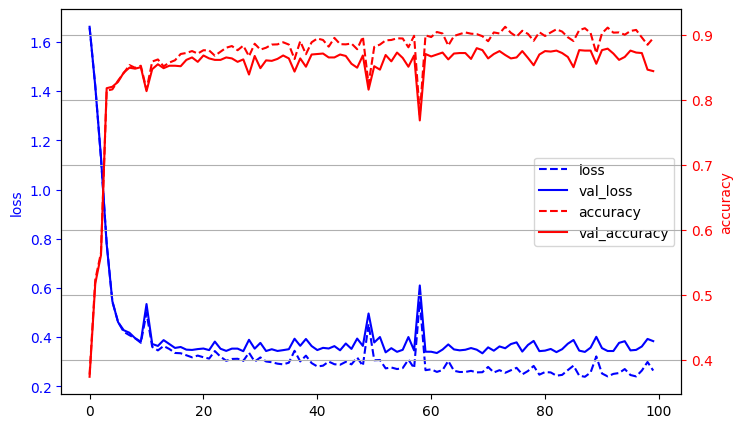

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

# Evaluate model on the testing set, get the csv file and upload to kaggle
 - Note: Do not modify this block of code

In [22]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ImageId": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                df["Label"].append(pred.cpu().item())
    df["ImageId"] = [i+1 for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)



In [23]:
save_prediction_to_csv(dnn_model, test_loader, device) # should only modify the input model to this function

# Submit result to kaggle competition

- Regsiter Kaggle account using your private gmail [Kaggle](https://https://www.kaggle.com/)

- Lastly, you will need to download the `submission.csv` file and upload it to the Kaggle competition (url for competition is provided in Moodle).

- Remember to change your display your team name on the Leaderboard